We are at: 0, that is 0.0 pct.
We are at: 100, that is 1.0 pct.
We are at: 200, that is 2.0 pct.
We are at: 300, that is 3.0 pct.
We are at: 400, that is 4.0 pct.
We are at: 500, that is 5.0 pct.
We are at: 600, that is 6.0 pct.
We are at: 700, that is 7.000000000000001 pct.
We are at: 800, that is 8.0 pct.
We are at: 900, that is 9.0 pct.
We are at: 1000, that is 10.0 pct.
We are at: 1100, that is 11.0 pct.
We are at: 1200, that is 12.0 pct.
We are at: 1300, that is 13.0 pct.
We are at: 1400, that is 14.000000000000002 pct.
We are at: 1500, that is 15.0 pct.
We are at: 1600, that is 16.0 pct.
We are at: 1700, that is 17.0 pct.
We are at: 1800, that is 18.0 pct.
We are at: 1900, that is 19.0 pct.
We are at: 2000, that is 20.0 pct.
We are at: 2100, that is 21.0 pct.
We are at: 2200, that is 22.0 pct.
We are at: 2300, that is 23.0 pct.
We are at: 2400, that is 24.0 pct.
We are at: 2500, that is 25.0 pct.
We are at: 2600, that is 26.0 pct.
We are at: 2700, that is 27.0 pct.
We are at: 280

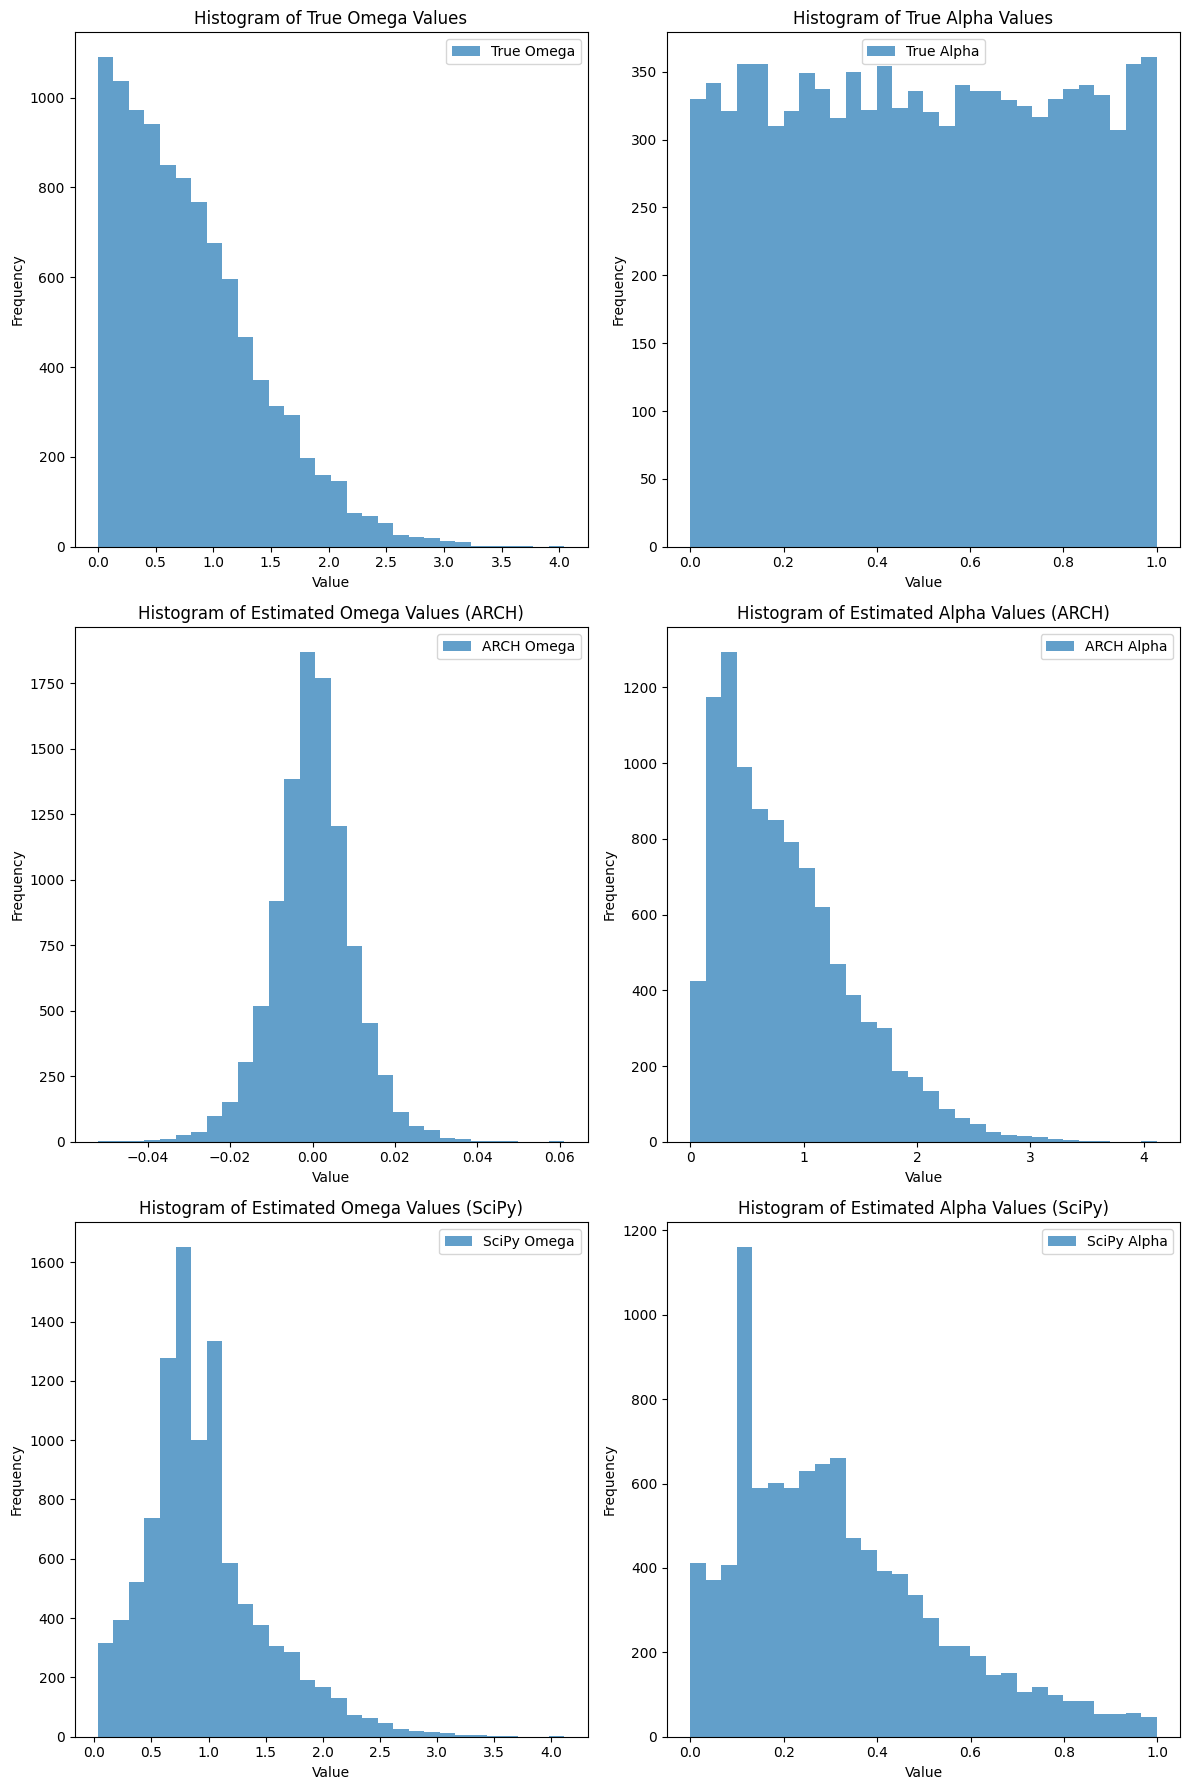

,omega_true,alpha_true,omega_arch,alpha_arch,omega_scipy,alpha_scipy,omega_diff_arch,alpha_diff_arch,omega_diff_scipy,alpha_diff_scipy
0,0.667428,0.070620,-0.003414,0.679309,0.679288,0.079367,0.670843,-0.608688,-0.011860,-0.008747
1,0.686009,0.696459,0.012466,0.728291,0.728823,0.512266,0.673544,-0.031832,-0.042814,0.184192
2,1.211092,0.385263,0.005213,1.182279,1.183746,0.255079,1.205879,-0.797016,0.027346,0.130184
3,0.310459,0.737954,0.004131,0.366473,0.366431,0.859659,0.306328,0.371481,-0.055972,-0.121705
4,1.358698,0.398338,0.003520,1.439792,1.439999,0.213765,1.355178,-1.041454,-0.081301,0.184573


In [7]:
import numpy as np
import pandas as pd
from arch import arch_model
from scipy.optimize import minimize
import warnings



# Suppressing warnings

warnings.filterwarnings('ignore')

# Parameters
num_simulations = 10000
num_obs = 10000

# Logging data
log_data = []

# Function to generate ARCH(1) time series
def generate_arch1_series(omega, alpha, num_obs):
    np.random.seed()  # Reset the random seed for each simulation
    eps = np.random.normal(size=num_obs)
    var = np.zeros_like(eps)
    var[0] = omega / (1 - alpha)
    for t in range(num_obs):
        var[t] = omega + alpha * eps[t - 1] ** 2
    return eps * np.sqrt(var)

# Function for the negative log-likelihood of ARCH(1) model
def arch1_log_likelihood(params, data):
    omega, alpha = params
    T = len(data)
    eps = data
    var = np.zeros_like(eps)
    var[0] = omega / (1 - alpha)
    for t in range(1, T):
        var[t] = omega + alpha * eps[t - 1] ** 2
    log_likelihood = -0.5 * (np.log(2 * np.pi) + np.log(var) + eps**2 / var)
    return -np.sum(log_likelihood)

# Monte Carlo Simulation
for _ in range(num_simulations):
    # Random omega and alpha
    omega_true = np.abs(np.random.randn())
    alpha_true = np.random.uniform(0, 1)

    # Generate ARCH(1) series
    data = generate_arch1_series(omega_true, alpha_true, num_obs)

    # Estimation with ARCH library
    model = arch_model(data, vol='ARCH', p=1)
    res_arch = model.fit(disp='off')
    omega_arch, alpha_arch = res_arch.params[0], res_arch.params[1]

    # Numerical estimation using SciPy's minimize
    initial_params = [0.1, 0.1]  # initial guesses
    bounds = [(0, None), (0, 1)] # bounds for omega and alpha
    res_scipy = minimize(arch1_log_likelihood, initial_params, args=(data,), bounds=bounds)
    omega_scipy, alpha_scipy = res_scipy.x

    # Log data
    log_data.append({
        'omega_true': omega_true,
        'alpha_true': alpha_true,
        'omega_arch': omega_arch,
        'alpha_arch': alpha_arch,
        'omega_scipy': omega_scipy,
        'alpha_scipy': alpha_scipy,
        'omega_diff_arch': omega_true - omega_arch,
        'alpha_diff_arch': alpha_true - alpha_arch,
        'omega_diff_scipy': omega_true - omega_scipy,
        'alpha_diff_scipy': alpha_true - alpha_scipy
    })
    if _%100 == 0:
        print(f'We are at: {_}, that is {round(_/num_simulations,3)*100} pct.')
# Convert to DataFrame for analysis
log_df = pd.DataFrame(log_data)

# Plot histograms
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(12, 18))

# Histogram of true omega and alpha values
axes[0, 0].hist(log_df['omega_true'], bins=30, alpha=0.7, label='True Omega')
axes[0, 1].hist(log_df['alpha_true'], bins=30, alpha=0.7, label='True Alpha')

# Histogram of estimated values
axes[1, 0].hist(log_df['omega_arch'], bins=30, alpha=0.7, label='ARCH Omega')
axes[1, 1].hist(log_df['alpha_arch'], bins=30, alpha=0.7, label='ARCH Alpha')
axes[2, 0].hist(log_df['omega_scipy'], bins=30, alpha=0.7, label='SciPy Omega')
axes[2, 1].hist(log_df['alpha_scipy'], bins=30, alpha=0.7, label='SciPy Alpha')

# Titles and labels
axes[0, 0].set_title('Histogram of True Omega Values')
axes[0, 1].set_title('Histogram of True Alpha Values')
axes[1, 0].set_title('Histogram of Estimated Omega Values (ARCH)')
axes[1, 1].set_title('Histogram of Estimated Alpha Values (ARCH)')
axes[2, 0].set_title('Histogram of Estimated Omega Values (SciPy)')
axes[2, 1].set_title('Histogram of Estimated Alpha Values (SciPy)')

for ax in axes.flat:
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()

log_df.head()  # Displaying first few rows of the log data


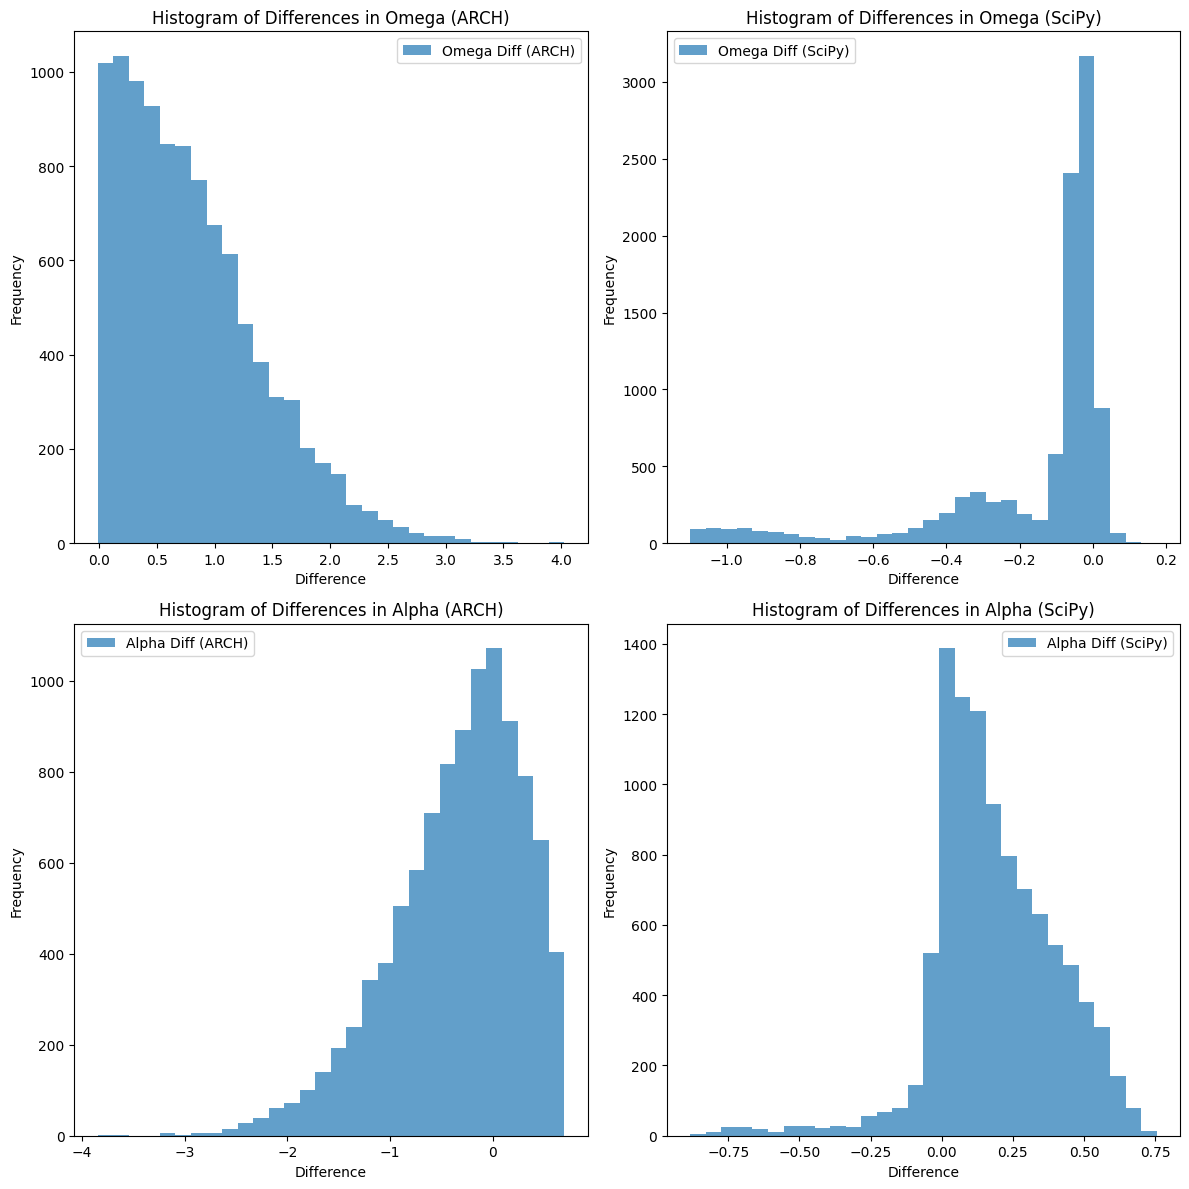

In [8]:
# Adjusting the plotting to show differences between true values and estimated values

fig, axes = plt.subplots(2, 2, figsize=(12, 12))



# Histogram of differences for Omega

axes[0, 0].hist(log_df['omega_diff_arch'], bins=30, alpha=0.7, label='Omega Diff (ARCH)')

axes[0, 1].hist(log_df['omega_diff_scipy'], bins=30, alpha=0.7, label='Omega Diff (SciPy)')



# Histogram of differences for Alpha

axes[1, 0].hist(log_df['alpha_diff_arch'], bins=30, alpha=0.7, label='Alpha Diff (ARCH)')

axes[1, 1].hist(log_df['alpha_diff_scipy'], bins=30, alpha=0.7, label='Alpha Diff (SciPy)')



# Titles and labels

axes[0, 0].set_title('Histogram of Differences in Omega (ARCH)')

axes[0, 1].set_title('Histogram of Differences in Omega (SciPy)')

axes[1, 0].set_title('Histogram of Differences in Alpha (ARCH)')

axes[1, 1].set_title('Histogram of Differences in Alpha (SciPy)')



for ax in axes.flat:

    ax.set_xlabel('Difference')

    ax.set_ylabel('Frequency')

    ax.legend()



plt.tight_layout()

plt.show()